In [3]:
from glob import glob
import re
import numpy as np
def convert_path(p):
    # Replace the folder part
    
    p = re.sub(r'^idd20kII/leftImg8bit/train', 'idd20kII/gtFine/train', p)
    # Replace the filename part
    p = re.sub(r'_leftImg8bit\.jpg$', '_gtFine_polygons.json', p)
    return p

image = glob('idd20kII/leftImg8bit/train/*/*_leftImg8bit.jpg')
labels= [convert_path(p) for p in image]

print(f"Length of the dataset: {len(image)} and {len(labels)}" )
print(image[0], labels[0])

Length of the dataset: 7034 and 7034
idd20kII/leftImg8bit/train/548/0017728_leftImg8bit.jpg idd20kII/gtFine/train/548/0017728_gtFine_polygons.json


In [4]:
dataset=list(zip(image,labels))

In [5]:
import cv2
import json

colors = {
    'animal': (123, 113, 163),
    'autorickshaw': (132, 244, 127),
    'bicycle': (78, 10, 89),
    'billboard': (202, 234, 146),
    'bridge': (106, 83, 176),
    'building': (2, 187, 159),
    'bus': (179, 128, 239),
    'car': (54, 3, 145),
    'caravan': (22, 151, 149),
    'curb': (210, 67, 86),
    'drivable fallback': (45, 1, 55),
    'ego vehicle': (88, 229, 255),
    'fallback background': (187, 201, 150),
    'fence': (23, 245, 48),
    'ground': (251, 215, 108),
    'guard rail': (69, 206, 233),
    'license plate': (55, 78, 143),
    'motorcycle': (201, 103, 43),
    'non-drivable fallback': (18, 204, 64),
    'obs-str-bar-fallback': (128, 97, 141),
    'out of roi': (239, 34, 227),
    'parking': (84, 44, 78),
    'person': (17, 223, 133),
    'pole': (57, 121, 241),
    'polegroup': (136, 231, 194),
    'rail track': (120, 6, 75),
    'rectification border': (145, 94, 79),
    'rider': (163, 149, 253),
    'road': (85, 179, 52),
    'sidewalk': (6, 228, 159),
    'sky': (76, 62, 93),
    'traffic light': (154, 88, 174),
    'traffic sign': (92, 246, 147),
    'trailer': (53, 144, 121),
    'train': (165, 153, 30),
    'truck': (28, 91, 72),
    'tunnel': (10, 42, 84),
    'unlabeled': (24, 2, 34),
    'vegetation': (134, 4, 185),
    'vehicle fallback': (158, 91, 32),
    'wall': (242, 253, 127),
    'others': (0, 0, 0)
}


In [6]:
json.load(open(labels[0]))

{'imgHeight': 1080,
 'imgWidth': 1920,
 'objects': [{'date': '19-Jul-2019 10:51:05',
   'deleted': 0,
   'draw': True,
   'id': 0,
   'label': 'obs-str-bar-fallback',
   'polygon': [[231.51381215469615, 237.48066298342542],
    [258.96132596685084, 247.02762430939228],
    [254.18784530386742, 266.121546961326],
    [258.96132596685084, 287.6022099447514],
    [270.8950276243094, 300.7292817679558],
    [286.4088397790055, 325.7900552486188],
    [294.76243093922653, 346.0773480662984],
    [316.24309392265195, 344.8839779005525],
    [318.62983425414365, 344.8839779005525],
    [318.62983425414365, 349.65745856353595],
    [286.4088397790055, 352.04419889502765],
    [221.9668508287293, 363.97790055248623],
    [213.6132596685083, 365.17127071823205],
    [211.22651933701658, 360.39779005524866],
    [217.19337016574588, 321.0165745856354],
    [224.35359116022101, 305.50276243093924],
    [224.35359116022101, 294.76243093922653],
    [220.77348066298345, 262.5414364640884],
    [220.

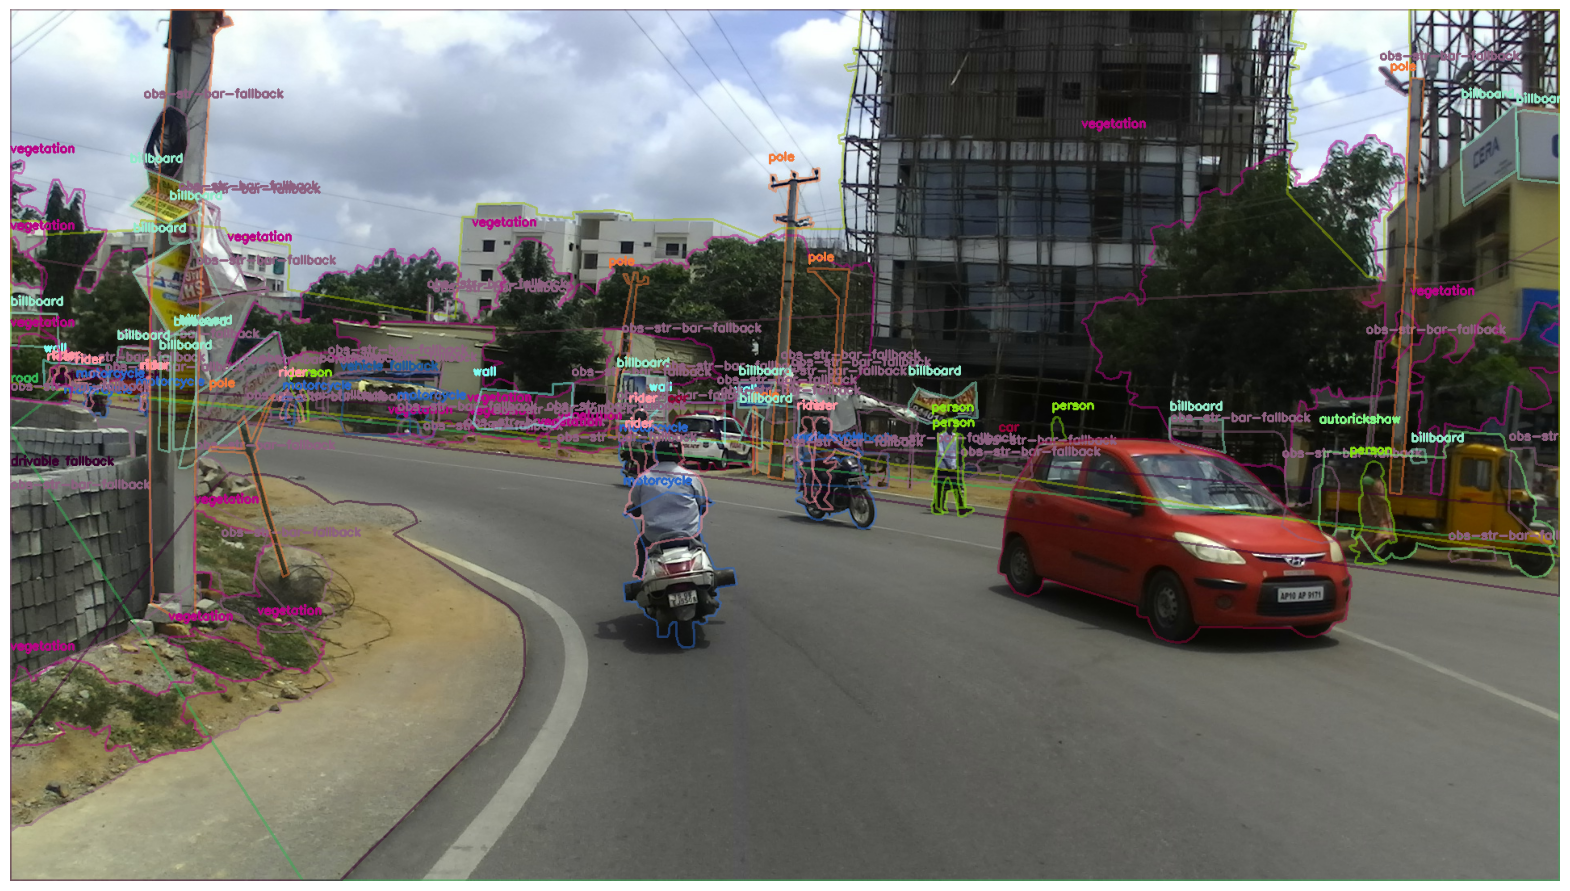

In [7]:
import matplotlib.pyplot as plt

def annotate_image(image, objects, alpha=0.5, show_text=False, show_labels=False,colors=colors):
    for obj in objects:
        label = obj.get("label")
        polygon = obj.get("polygon")
        if not polygon:
            continue  # skip if no polygon info
        pts = np.array(polygon, dtype=np.float32)
        pts = np.round(pts).astype(np.int32).reshape((-1, 1, 2))
        color = colors.get(label, colors['others'])
        
        overlay = image.copy()
        cv2.polylines(overlay, [pts], isClosed=True, color=color, thickness=2)
        image = cv2.addWeighted(overlay, alpha, image, 1-alpha, 0)
        
        if show_text:
            x, y, w, h = cv2.boundingRect(pts)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    if show_labels:
        legend_x, legend_y = 10, 30
        for lbl, clr in colors.items():
            cv2.rectangle(image, (legend_x, legend_y), (legend_x+20, legend_y+20), clr, -1)
            cv2.putText(image, lbl, (legend_x+30, legend_y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, clr, 2)
            legend_y += 30
        


    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 20))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


annotate_image(cv2.imread(dataset[0][0]), json.load(open(dataset[0][1]))['objects'],show_text=True)

In [8]:
len(colors)

42

# Converting into COCO format

In [9]:

def polygon_to_bbox(polygon):
    """
    Convert a polygon (list of [x, y] points) into a bounding box [x_min, y_min, width, height].
    """
    xs = [pt[0] for pt in polygon]
    ys = [pt[1] for pt in polygon]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    return [x_min, y_min, x_max - x_min, y_max - y_min]

def flatten_polygon(polygon):
    """
    Flatten a list of [x, y] into [x1, y1, x2, y2, ...].
    """
    return [coord for pt in polygon for coord in pt]

In [ ]:
OUTPUT_JSON = "train_coco.json"
def convert_to_coco(dataset, output_json):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    image_id = 1
    annotation_id = 1
    label_to_id = {}
    for image_path, label_path in dataset:
        with open(label_path, 'r') as f:
            data = json.load(f)
        img_width, img_height = data.get('imgWidth'), data.get('imgHeight')

        coco_output["images"].append({
            "id": image_id,
            "file_name": image_path,
            "width": img_width,
            "height": img_height
        })
        for obj in data.get("objects"):
            label = obj.get("label")
            polygon= obj.get("polygon")
            if not polygon:
                continue
            if label not in label_to_id:
                label_to_id[label] = len(label_to_id) + 1

            category_id = label_to_id[label]

            segmentaion = [flatten_polygon(obj.get("polygon"))]

            bbox = polygon_to_bbox(obj.get("polygon"))

            area = bbox[2] * bbox[3]

            annotation = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": segmentaion,
                "bbox": bbox,
                "area": area,
                "iscrowd": 0
            }
            
            coco_output["annotations"].append(annotation)
            annotation_id += 1
        
        image_id += 1

    for label, cat_id in label_to_id.items():
        coco_output["categories"].append({
            "id": cat_id,
            "name": label,
            "supercategory": "none"
        })

    # Save final COCO-style JSON
    with open(output_json, "w") as f:
        json.dump(coco_output, f, indent=4)

    print(f"COCO conversion complete! Saved to {OUTPUT_JSON}")


COCO conversion complete! Saved to train_coco.json


In [ ]:
def show_annotations(image_path, anns, show_bbox=True, show_polygon=False):
    """
    Display an image with annotation overlays.
    
    Parameters:
      image_path (str): path to the image file.
      anns (list): list of annotations (COCO-style) for the image.
      show_bbox (bool): whether to draw bounding boxes.
      show_polygon (bool): whether to draw segmentation polygons.
    """
    img = cv2.imread(image_path)
    overlay = img.copy()
    
    for ann in anns:
        if show_bbox:
            x, y, w, h = ann["bbox"]
            cv2.rectangle(overlay, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
        if show_polygon:
            # COCO segmentation is stored as a list of lists
            seg_flat = ann["segmentation"][0]
            pts = np.array(seg_flat, dtype=np.float32).reshape(-1, 2).astype(np.int32)
            cv2.polylines(overlay, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    
    image_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 20))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()
